# **Lab 10 - Vanilla CNN and Fine-Tune VGG16 - for Dogs and Cats Classification**

[Visit github page](https://github.com/imdarshik/CSCN8010-labs/tree/main/week10)

### **1. Introduction**

In this lab, we'll explore common practices in Deep Learning Engineering, focusing on fine-tuning existing models for specific tasks. Our objective is to classify images of dogs and cats using the Dogs vs Cats dataset

In [57]:
# Import necessary libraries
import matplotlib.pyplot as plt  # For plotting
import os  # For operating system related operations
import pandas as pd  # For data manipulation
import tensorflow as tf  # TensorFlow library
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image data preprocessing
from tensorflow import keras  # Keras API for TensorFlow
from tensorflow.keras import layers  # Layers module for defining model architecture
from keras.models import load_model  # For loading pre-trained models
from tqdm import tqdm  # For progress visualization
import numpy as np  # For numerical computations
import warnings  # For handling warnings
# Suppressing warnings
warnings.filterwarnings("ignore")
# Importing evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  
# Additional import of numpy for numerical computations
import numpy as np
import seaborn as sns
import cv2

### **2. Data Acquisition and Preparation**

We acquire the dataset from Kaggle, extract it, and store it locally in the directory named "data/train".

In [6]:
# Listing all filenames in the 'data/train/' directory
train_filenames = os.listdir("data/train/")

# Creating a DataFrame with the filenames
paths = pd.DataFrame(train_filenames, columns=["filenames"])

# Extracting the id from the filenames
paths["id"] = paths["filenames"].transform(lambda x: str(x).split('.')[1])

# Extracting the label from the filenames
paths["label"] = paths["filenames"].transform(lambda x: str(x).split('.')[0])

# Mapping the label 'cat' to 0 and 'dog' to 1, and creating a new column 'category'
paths["category"] = paths["label"].map({"dog": 1, "cat": 0})

# Displaying the first few rows of the DataFrame
paths.head()

filenames    id label  category
0     cat.0.jpg     0   cat         0
1     cat.1.jpg     1   cat         0
2    cat.10.jpg    10   cat         0
3   cat.100.jpg   100   cat         0
4  cat.1000.jpg  1000   cat         0

### **3. Exploratory Data Analysis (EDA)**

#### **Sample Distribution between Cats and Dogs**

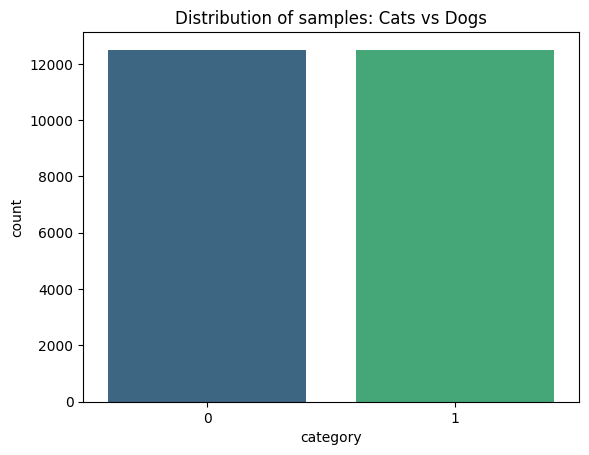

In [56]:
# Visualize the distribution of samples between cats and dogs
sns.countplot(x=paths["category"], palette="viridis")  # Create a count plot using seaborn
plt.title("Distribution of samples: Cats vs Dogs")  # Set the title of the plot
plt.show()  # Display the plot

From the graph, it's evident that the number of samples is evenly distributed across classes

#### **Visualizing Random Sample Images from the Dataset**

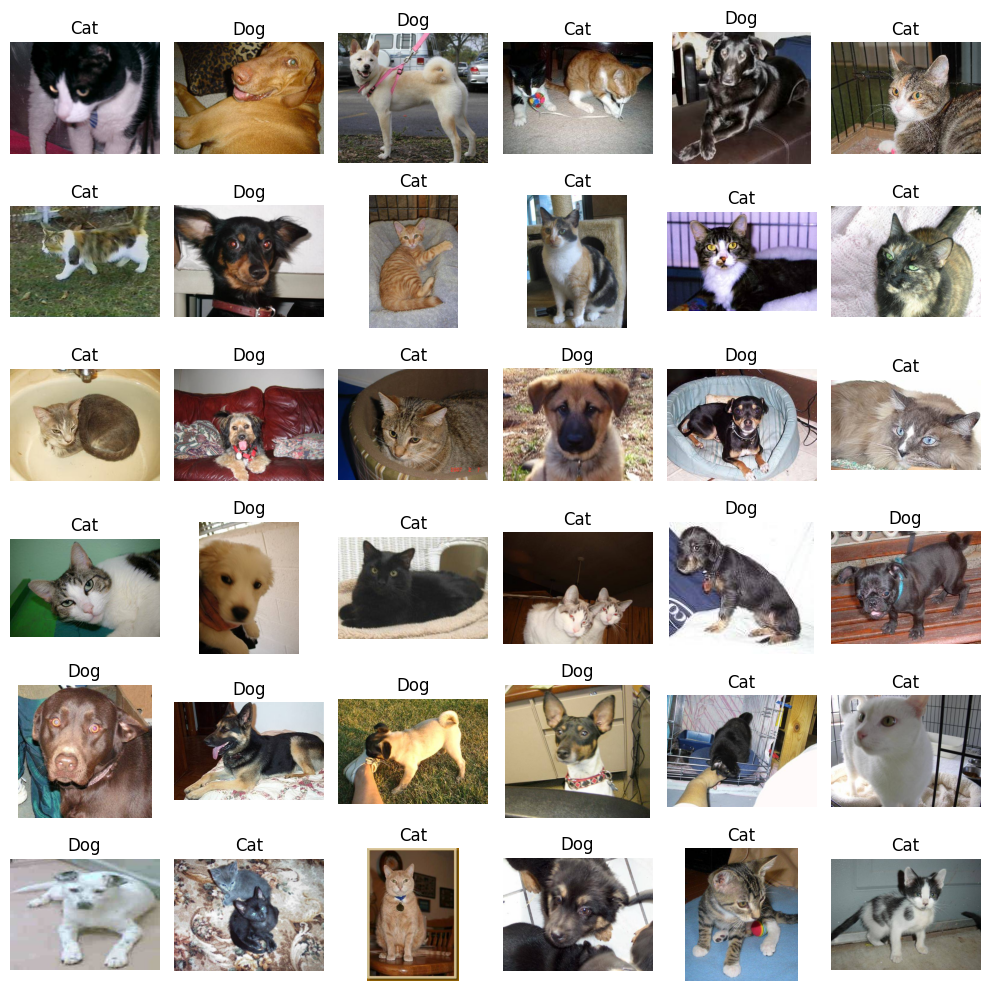

In [24]:
# Select random subset of images
sample_paths = paths.sample(36)

# Plot the images in a grid layout
plt.figure(figsize=(10, 10))
for i in range(len(sample_paths)):
    # Read and plot the image
    image_path = os.path.join("data/train", sample_paths.iloc[i]['filenames'])
    image = plt.imread(image_path)
    plt.subplot(6, 6, i+1)
    plt.imshow(image)
    plt.axis('off')
    # Set title based on the label (cat or dog)
    if sample_paths.iloc[i]['label'] == 'cat':
        plt.title('Cat')
    else:
        plt.title('Dog')

plt.tight_layout()
plt.show()

From the images, it's apparent that there are variations in the aspect ratio, height, and width between cat and dog images. Additionally, the images exhibit varying pixel intensities and depict a variety of dog and cat breeds

#### **Image Height and width distribution**

100%|██████████| 25000/25000 [00:29<00:00, 858.95it/s]


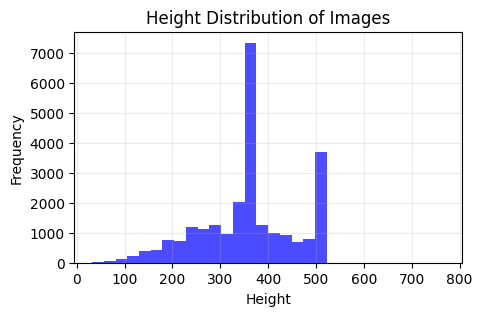

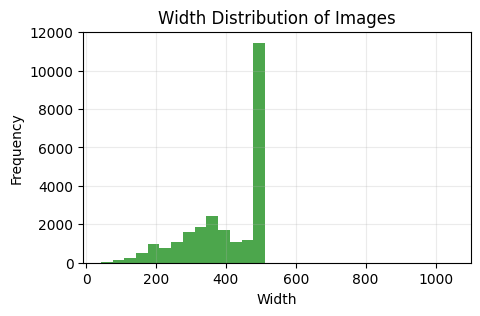

In [30]:
# Directory containing the images
image_dir = "data/train/"

# Initialize lists to store heights and widths
heights = []
widths = []

# Iterate through each image in the directory
for filename in tqdm(paths["filenames"]):
    # Read the image using OpenCV
    image_path = os.path.join(image_dir, filename)
    image = cv2.imread(image_path)
    # Get the height and width of the image
    height, width, _ = image.shape
    heights.append(height)
    widths.append(width)

# Plot the distribution of heights
plt.figure(figsize=(5, 3))
plt.hist(heights, bins=30, color='blue', alpha=0.7)
plt.title('Height Distribution of Images')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.grid(alpha=0.25)
plt.show()

# Plot the distribution of widths
plt.figure(figsize=(5, 3))
plt.hist(widths, bins=30, color='green', alpha=0.7)
plt.title('Width Distribution of Images')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.grid(alpha=0.25)
plt.show()

Images come in a range of resolutions, spanning from low-quality to moderate-quality images

#### **Image statistics across category**

In [49]:
# Directory containing the images
image_directory = "data/train/"

# Initialize lists to store image statistics
cat_mean_pixel_values = []
cat_std_dev_pixel_values = []
cat_min_pixel_values = []
cat_max_pixel_values = []

dog_mean_pixel_values = []
dog_std_dev_pixel_values = []
dog_min_pixel_values = []
dog_max_pixel_values = []

# Iterate through each image in the directory
for filename, label in tqdm(list(zip(paths["filenames"].to_list(),paths["label"].to_list()))):
    # Read the image using OpenCV
    image_path = os.path.join(image_directory, filename)
    image = cv2.imread(image_path)
    
    # Convert the image to grayscale if it's not already grayscale
    if len(image.shape) > 2:
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        grayscale_image = image
    
    
    # Compute image statistics
    mean_pixel_value = np.mean(grayscale_image)
    std_dev_pixel_value = np.std(grayscale_image)
    min_pixel_value = np.min(grayscale_image)
    max_pixel_value = np.max(grayscale_image)
    
    if label == "cat":
        # Append image statistics to the lists
        cat_mean_pixel_values.append(mean_pixel_value)
        cat_std_dev_pixel_values.append(std_dev_pixel_value)
        cat_min_pixel_values.append(min_pixel_value)
        cat_max_pixel_values.append(max_pixel_value)
    else:
        # Append image statistics to the lists
        dog_mean_pixel_values.append(mean_pixel_value)
        dog_std_dev_pixel_values.append(std_dev_pixel_value)
        dog_min_pixel_values.append(min_pixel_value)
        dog_max_pixel_values.append(max_pixel_value)

# Aggregate the image statistics to get overall statistics for the entire dataset
cat_overall_mean_pixel_value = np.mean(cat_mean_pixel_values)
cat_overall_std_dev_pixel_value = np.mean(cat_std_dev_pixel_values)
cat_overall_min_pixel_value = np.min(cat_min_pixel_values)
cat_overall_max_pixel_value = np.max(cat_max_pixel_values)

# Print the overall image statistics
print("CAT : ")
print("Overall Mean Pixel Value:", cat_overall_mean_pixel_value)
print("Overall Standard Deviation of Pixel Values:", cat_overall_std_dev_pixel_value)
print("Overall Minimum Pixel Value:", cat_overall_min_pixel_value)
print("Overall Maximum Pixel Value:", cat_overall_max_pixel_value)

# Aggregate the image statistics to get overall statistics for the entire dataset
dog_overall_mean_pixel_value = np.mean(dog_mean_pixel_values)
dog_overall_std_dev_pixel_value = np.mean(dog_std_dev_pixel_values)
dog_overall_min_pixel_value = np.min(dog_min_pixel_values)
dog_overall_max_pixel_value = np.max(dog_max_pixel_values)

# Print the overall image statistics
print("DOG : ")
print("Overall Mean Pixel Value:", dog_overall_mean_pixel_value)
print("Overall Standard Deviation of Pixel Values:", dog_overall_std_dev_pixel_value)
print("Overall Minimum Pixel Value:", dog_overall_min_pixel_value)
print("Overall Maximum Pixel Value:", dog_overall_max_pixel_value)

  0%|          | 0/25000 [00:00<?, ?it/s]

100%|██████████| 25000/25000 [00:57<00:00, 435.08it/s]

CAT : 
Overall Mean Pixel Value: 116.19177446281728
Overall Standard Deviation of Pixel Values: 57.931538719908765
Overall Minimum Pixel Value: 0
Overall Maximum Pixel Value: 255
DOG : 
Overall Mean Pixel Value: 118.76681394026781
Overall Standard Deviation of Pixel Values: 55.59723640538584
Overall Minimum Pixel Value: 0
Overall Maximum Pixel Value: 255


Based on the statistics, both cat and dog images exhibit similar characteristics in terms of pixel values. The mean pixel value for cats is approximately 116.19, with a standard deviation of around 57.93, while for dogs, the mean pixel value is roughly 118.77, with a standard deviation of about 55.60. The pixel values range from 0 to 255 for both cats and dogs, indicating a diverse range of intensity levels in the images.

### **4. Model Development**

In [10]:
# Split paths into train and validation sets
# 20% of the data is used for validation
# Stratify ensures class balance in both sets
train_paths, validate_paths = train_test_split(paths, test_size=0.20, random_state=42, stratify=paths["category"])

# Reset index for both sets for continuous indexing
train_paths = train_paths.reset_index(drop=True)
validate_paths = validate_paths.reset_index(drop=True)

# Print shapes of train and validation sets
print(train_paths.shape)
print(validate_paths.shape)

(20000, 4)
(5000, 4)


In [11]:
# Counting the occurrences of each category in the 'category' column
train_paths["category"].value_counts()

category
1    10000
0    10000
Name: count, dtype: int64

In [31]:
# Data augmentation for training data
train_datagenerator = ImageDataGenerator(
    rotation_range=15,  # Random rotation up to 15 degrees
    rescale=1./255,  # Rescale pixel values to [0, 1]
    shear_range=0.1,  # Shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Horizontal flipping
    width_shift_range=0.1,  # Random width shift
    height_shift_range=0.1  # Random height shift
)

# Data preprocessing for validation data
valid_datagenerator = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]

# Generate batches of training data
train_generator = train_datagenerator.flow_from_dataframe(
    train_paths,  # DataFrame containing paths and labels
    "data/train/",  # Path to the directory containing images
    x_col='filenames',  # Column name containing filenames
    y_col='label',  # Column name containing labels
    target_size=(180, 180),  # Resize images to (180, 180)
    class_mode='binary',  # Binary classification
    batch_size=64  # Batch size
)

# Generate batches of validation data
validation_generator = valid_datagenerator.flow_from_dataframe(
    validate_paths,  # DataFrame containing paths and labels
    "data/train/",  # Path to the directory containing images
    x_col='filenames',  # Column name containing filenames
    y_col='label',  # Column name containing labels
    target_size=(180, 180),  # Resize images to (180, 180)
    class_mode='binary',  # Binary classification
    batch_size=64  # Batch size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


  0%|          | 0/79 [00:00<?, ?it/s]

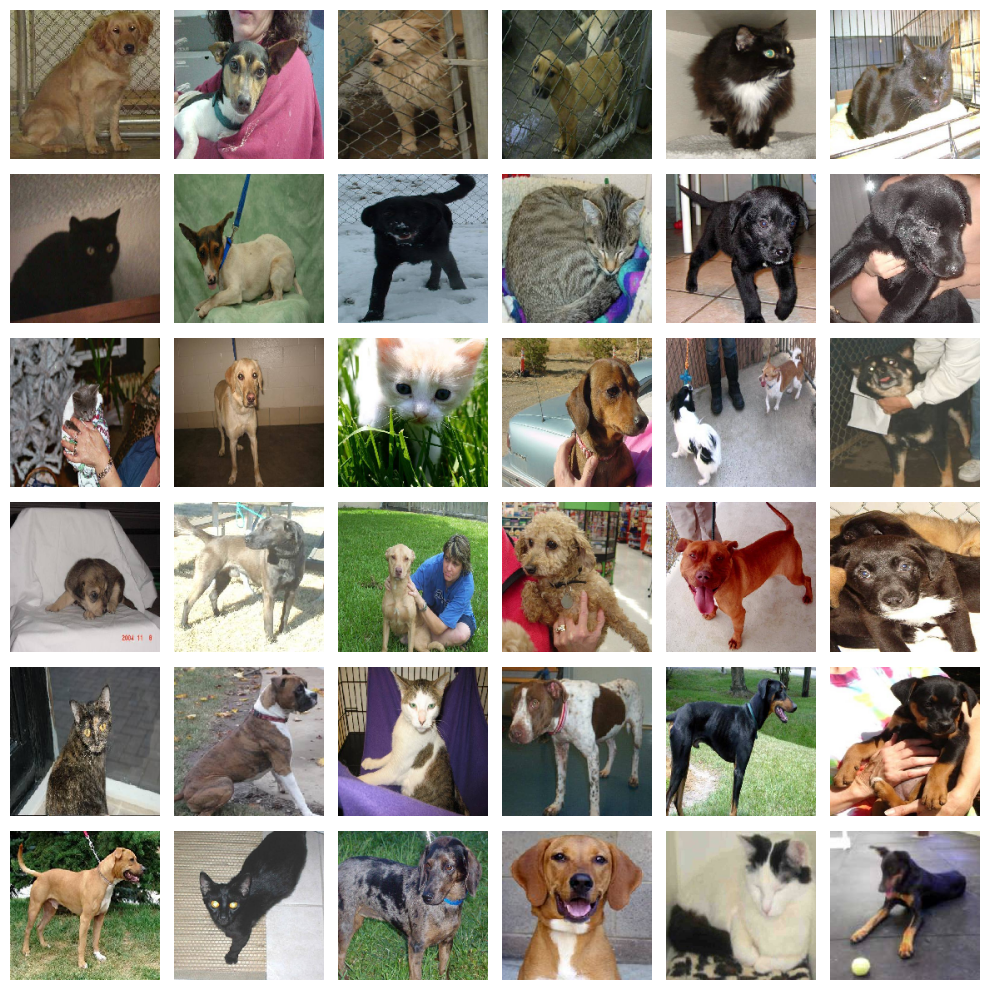

  0%|          | 0/79 [00:01<?, ?it/s]


In [38]:
# Wrap the test generator with tqdm for progress visualization
for test_data, test_labels in tqdm(validation_generator):
    # Unnormalize the test data by multiplying by 255
    test_data *= 255.0
    
    # Plot 36 images in a 6x6 grid
    plt.figure(figsize=(10, 10))
    for i in range(36):
        plt.subplot(6, 6, i + 1)
        plt.imshow(test_data[i].astype('uint8'))  # Convert to uint8 for correct plotting
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Break the loop after plotting the first batch
    break

In [13]:
# Get the total number of samples in the training and validation sets
total_train = train_paths.shape[0]  # Total samples in the training set
total_validate = validate_paths.shape[0]  # Total samples in the validation set

# Define the batch size for training and validation data
batch_size = 64  # Number of samples per batch

#### **Vanilla CNN**

In [20]:
# Code reference: https://github.com/imdarshik/CSCN8010/blob/main/dl_class_notebooks/05C_dogs_vs_cats_cnn_and_data_augmentation.ipynb
# Define the input layer with shape (180, 180, 3)
inputs = keras.Input(shape=(180, 180, 3))
# Convolutional layers with ReLU activation
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
# Flatten layer to convert 2D features to 1D
x = layers.Flatten()(x)
# Output layer with sigmoid activation for binary classification
outputs = layers.Dense(1, activation="sigmoid")(x)
# Define the model with input and output layers
model = keras.Model(inputs=inputs, outputs=outputs)

In [21]:
# Print summary of the model architecture
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Compile the model with binary cross-entropy loss function,
# RMSprop optimizer, and accuracy metric
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

# Define a callback to save the best model during training
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Train the model using fit method
# train_generator provides training data batches
# validation_generator provides validation data batches
# callbacks argument specifies the ModelCheckpoint callback for saving the best model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 169s 533ms/step - accuracy: 0.9415 - loss: 0.1555 - val_accuracy: 0.9424 - val_loss: 0.1545
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 174s 550ms/step - accuracy: 0.9429 - loss: 0.1447 - val_accuracy: 0.9320 - val_loss: 0.1659
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 173s 549ms/step - accuracy: 0.9368 - loss: 0.1580 - val_accuracy: 0.9518 - val_loss: 0.1433
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 177s 560ms/step - accuracy: 0.9441 - loss: 0.1487 - val_accuracy: 0.9392 - val_loss: 0.1868
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 177s 560ms/step - accuracy: 0.9403 - loss: 0.1593 - val_accuracy: 0.9486 - val_loss: 0.1373
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 593s 2s/step - accuracy: 0.9438 - loss: 0.1486 - val_accuracy: 0.9264 - val_loss: 0.2186
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 779s 2s/step - accuracy: 0.9389 - loss: 0.1511 - val_accuracy: 0.9492 - val_loss: 0.1703
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 736s 2s/step - accuracy: 0.9418 - loss: 0.

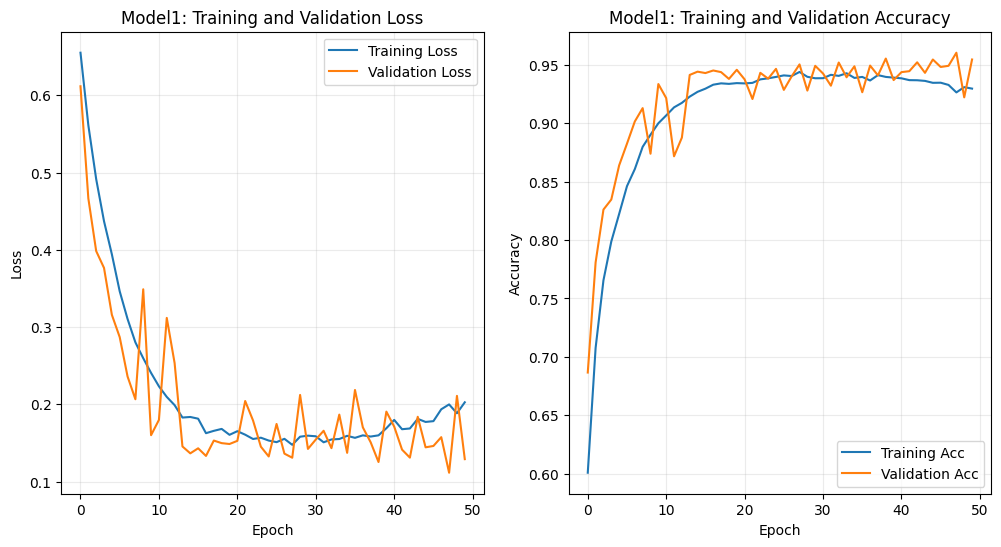

In [32]:
# Extract training and validation loss and accuracy from the training history (Training has been run twice, first fit was set for 30 epochs, and second run was set for 20 more epochs)
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model1: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.25)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
plt.title('Model1: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.25)

Around epoch 27, the training and validation loss as well as accuracy indicate optimal fitting.

#### **VGG16**

In [138]:
# Load the pre-trained VGG16 model with weights from ImageNet dataset
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",  # Use pre-trained weights
    include_top=False,  # Exclude the fully connected layers at the top
    input_shape=(224, 224, 3)  # Input shape of the images
)

# Freeze the layers except the last 4 convolutional layers
for i, layer in list(enumerate(conv_base.layers))[:-4]: layer.trainable = False
# Unfreeze the last 4 convolutional layers
for i, layer in list(enumerate(conv_base.layers))[-4:]: layer.trainable = True
# Get the output tensor of the last convolutional layer
last_layer = conv_base.get_layer('block5_pool')
last_output = last_layer.output
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout layer with a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for binary classification
x = layers.Dense(1, activation='sigmoid')(x)
# Create the model by specifying the input and output layers
model2 = tf.keras.Model(conv_base.input, x)

In [145]:
# Print summary of the model architecture
model2.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d_3          │ (None, 512)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 7,342,593 (28.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [76]:
# Data augmentation for training data
train_datagenerator = ImageDataGenerator(
    rotation_range=15,  # Random rotation up to 15 degrees
    rescale=1./255,  # Rescale pixel values to [0, 1]
    shear_range=0.1,  # Shear transformation
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Horizontal flipping
    width_shift_range=0.1,  # Random width shift
    height_shift_range=0.1  # Random height shift
)

# Data preprocessing for validation data
valid_datagenerator = ImageDataGenerator(rescale=1./255)  # Rescale pixel values to [0, 1]

# Generate batches of training data
train_generator = train_datagenerator.flow_from_dataframe(
    train_paths,  # DataFrame containing paths and labels
    "data/train/",  # Path to the directory containing images
    x_col='filenames',  # Column name containing filenames
    y_col='label',  # Column name containing labels
    target_size=(224, 224),  # Resize images to (224, 224)
    class_mode='binary',  # Binary classification
    batch_size=16  # Batch size
)

# Generate batches of validation data
validation_generator = valid_datagenerator.flow_from_dataframe(
    validate_paths,  # DataFrame containing paths and labels
    "data/train/",  # Path to the directory containing images
    x_col='filenames',  # Column name containing filenames
    y_col='label',  # Column name containing labels
    target_size=(224, 224),  # Resize images to (224, 224)
    class_mode='binary',  # Binary classification
    batch_size=16  # Batch size
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [147]:
# Compile the model with binary cross-entropy loss, SGD optimizer with specific learning rate and momentum, and accuracy metric
model2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

# Define a callback to save the best model during training
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="models/convnet_from_scratch_2.keras",
        save_best_only=True,
        monitor="val_loss")
]

# Train the model using fit method
# train_generator provides training data batches
# validation_generator provides validation data batches
# callbacks argument specifies the ModelCheckpoint callback for saving the best model
history = model2.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks)

Epoch 1/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1966s 2s/step - accuracy: 0.7542 - loss: 0.4635 - val_accuracy: 0.9480 - val_loss: 0.1293
Epoch 2/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1655s 1s/step - accuracy: 0.9290 - loss: 0.1675 - val_accuracy: 0.9590 - val_loss: 0.1023
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1682s 1s/step - accuracy: 0.9457 - loss: 0.1330 - val_accuracy: 0.9640 - val_loss: 0.0917
Epoch 4/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1656s 1s/step - accuracy: 0.9540 - loss: 0.1161 - val_accuracy: 0.9538 - val_loss: 0.1144
Epoch 5/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1644s 1s/step - accuracy: 0.9597 - loss: 0.1047 - val_accuracy: 0.9694 - val_loss: 0.0791
Epoch 6/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1665s 1s/step - accuracy: 0.9635 - loss: 0.0894 - val_accuracy: 0.9702 - val_loss: 0.0779
Epoch 7/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1651s 1s/step - accuracy: 0.9620 - loss: 0.0941 - val_accuracy: 0.9698 - val_loss: 0.0790
Epoch 8/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 1646s 1s/step - accuracy: 0.9675 -

KeyboardInterrupt: 

The execution of the code has been interrupted due to the long runtime caused by setting the number of epochs to 50. After reaching epoch 15, it appears that the model has converged and is showing signs of overfitting. Therefore, we will proceed by selecting the best checkpoint obtained within the first 15 epochs of training

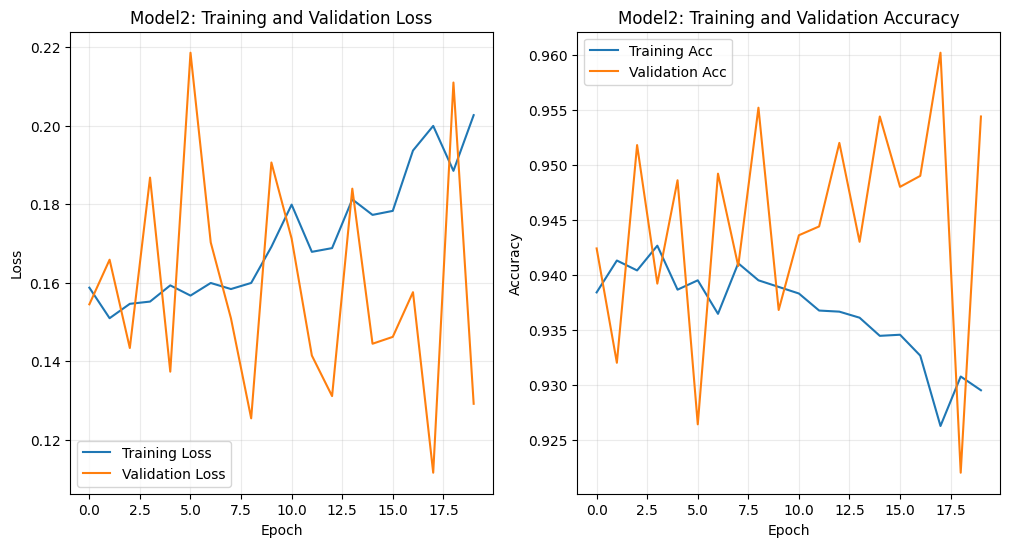

In [185]:
# Extract training and validation loss and accuracy from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting loss and accuracy curves
plt.figure(figsize=(12, 6))

# Plotting training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model2: Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.25)

# Plotting training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Acc')
plt.plot(val_acc, label='Validation Acc')
plt.title('Model2: Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.25)

Around epoch 3, the training and validation loss as well as accuracy indicate optimal fitting.

### **5. Model Evaluation**

In [58]:
# Load the best model checkpoints
best_model1 = load_model("models/convnet_from_scratch.keras")

# Compile the model with additional metrics
best_model1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'precision', 'recall', 'f1_score'])

# Evaluate the model
loss_values = []
accuracy_values = []
precision_values = []
recall_values = []
f1_score_values = []
counter = 0

# Wrap the test generator with tqdm for progress visualization
for test_data, test_labels in tqdm(validation_generator):
    if counter == len(validation_generator):
        break
    # Compute metrics for the current batch
    loss, accuracy, precision, recall, f1_score = best_model1.evaluate(test_data, test_labels.reshape((-1,1)), verbose=0)
    
    # Append metrics for the current batch to lists
    loss_values.append(loss)
    accuracy_values.append(accuracy)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_score_values.append(f1_score)
    counter += 1

# Compute the average metrics over all batches
avg_loss = np.mean(loss_values)
avg_accuracy = np.mean(accuracy_values)
avg_precision = np.mean(precision_values)
avg_recall = np.mean(recall_values)
avg_f1_score = np.mean(f1_score_values)

print('Average Loss:', avg_loss)
print('Average Accuracy:', avg_accuracy)
print('Average Precision:', avg_precision)
print('Average Recall:', avg_recall)
print('Average F1 Score:', avg_f1_score)

100%|██████████| 79/79 [00:18<00:00,  4.37it/s]

Average Loss: 0.11778790377599152
Average Accuracy: 0.9590585443037974
Average Precision: 0.8200661947455588
Average Recall: 0.9497021602678902
Average F1 Score: 0.9700415262693092


In [20]:
# Load the best model checkpoints
best_model2 = load_model("models/convnet_from_scratch_2.keras")

# Compile the model with additional metrics
best_model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'precision', 'recall', 'f1_score'])

# Evaluate the model
loss_values = []
accuracy_values = []
precision_values = []
recall_values = []
f1_score_values = []
counter = 0

# Wrap the test generator with tqdm for progress visualization
for test_data, test_labels in tqdm(validation_generator):
    if counter == len(validation_generator):
        break
    # Compute metrics for the current batch
    loss, accuracy, precision, recall, f1_score = best_model2.evaluate(test_data, test_labels.reshape((-1,1)), verbose=0)
    
    # Append metrics for the current batch to lists
    loss_values.append(loss)
    accuracy_values.append(accuracy)
    precision_values.append(precision)
    recall_values.append(recall)
    f1_score_values.append(f1_score)
    counter += 1

# Compute the average metrics over all batches
avg_loss = np.mean(loss_values)
avg_accuracy = np.mean(accuracy_values)
avg_precision = np.mean(precision_values)
avg_recall = np.mean(recall_values)
avg_f1_score = np.mean(f1_score_values)

print('Average Loss:', avg_loss)
print('Average Accuracy:', avg_accuracy)
print('Average Precision:', avg_precision)
print('Average Recall:', avg_recall)
print('Average F1 Score:', avg_f1_score)

100%|██████████| 313/313 [11:47<00:00,  2.26s/it]

Average Loss: 0.06754788329218367
Average Accuracy: 0.9752396166134185
Average Precision: 0.6574105251425753
Average Recall: 0.9746259599448012
Average F1 Score: 0.9756462031279128


Here are the results for Model 1 and Model 2:

**Model 1**:

- Average Loss: 0.1178
- Average Accuracy: 0.9590
- Average Precision: 0.8200
- Average Recall: 0.9497
- Average F1 Score: 0.9700

**Model 2 (Fine-tuned VGG16)**:

- Average Loss: 0.06755
- Average Accuracy: 0.9752
- Average Precision: 0.6574
- Average Recall: 0.9746
- Average F1 Score: 0.9756

Overall, Model 2 shows slightly better performance in terms of average loss and accuracy compared to Model 1. However, Model 1 demonstrates higher precision, while Model 2 exhibits higher recall and F1 score.

#### **Explore specific examples in which the model failed to predict correctly**

In [98]:
# Load the best model checkpoints
best_model2 = load_model("models/convnet_from_scratch_2.keras")

# Compile the model with additional metrics
best_model2.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'precision', 'recall', 'f1_score'])

# Lists to store error samples
error_samples = []
counter = 0

# Wrap the test generator with tqdm for progress visualization
for test_data, test_labels in tqdm(validation_generator):
    if counter == 2: break
    # Predict labels for the current batch
    predictions = best_model2.predict(test_data)
    # Iterate through each sample in the batch
    for i in range(len(test_labels)):
        # Check if the predicted label does not match the true label
        if predictions[i] != test_labels[i]:
            # Append the sample to the list of error samples
            error_samples.append((test_data[i], test_labels[i]))
    counter += 1

  0%|          | 0/313 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step


  0%|          | 1/313 [00:00<04:47,  1.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step


  1%|          | 2/313 [00:01<04:27,  1.16it/s]


In [99]:
# Convert the list of error samples to numpy array
error_samples = np.array([i[0] for i in error_samples])

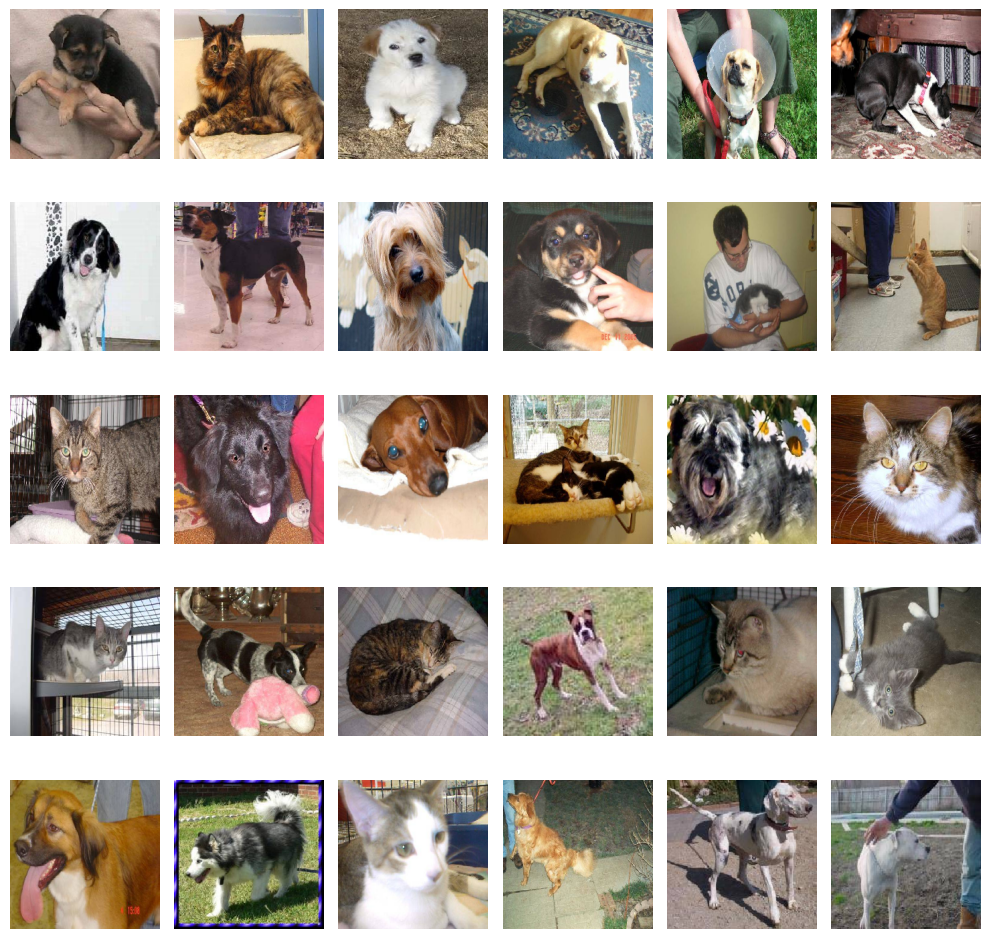

In [101]:
plt.figure(figsize=(10, 10))

# Wrap the test generator with tqdm for progress visualization
for i, test_data in enumerate(error_samples[:30]):
    # Unnormalize the test data by multiplying by 255
    test_data *= 255.0
    
    # Plot 36 images in a 6x6 grid
    plt.subplot(5, 6, i + 1)
    plt.imshow(test_data.astype('uint8'))  # Convert to uint8 for correct plotting
    plt.axis('off')
    
plt.tight_layout()
plt.show()

### **6. Conclusions**


In summary, our experiments with vanilla CNN and fine-tuned VGG16 for dogs vs cats classification revealed promising results. The model 2, which Fine-tuned VGG16 achieved balanced performance across evaluation metrics, showcasing the effectiveness of transfer learning.

In [105]:
# !jupyter nbconvert --to html Practical_lab10.ipynb